In [1]:
# 📦 셀 1: 환경 설정
!pip install -q ultralytics opencv-python-headless

import torch
print(f"✅ GPU 사용 가능: {torch.cuda.is_available()}")
print(f"   GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
✅ GPU 사용 가능: False
   GPU: None


In [2]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ============================================
# 기본 YOLOv8 모델 성능 평가 (학습 없이)
# Pretrained 모델의 Zero-shot 성능 측정
# ============================================

print("="*60)
print("📊 기본 모델 성능 평가 (Zero-shot)")
print("   학습 전 baseline 성능 측정")
print("="*60)

from ultralytics import YOLO
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np


class BaselineEvaluator:
    """기본 모델 (학습 전) 성능 평가"""

    def __init__(self, pretrained_model='yolov8n.pt'):
        """
        초기화

        Args:
            pretrained_model: 사전학습된 YOLO 모델
                            'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt' 등
        """
        print(f"\n🔧 기본 모델 로드: {pretrained_model}")
        print("   (COCO 데이터셋으로 사전 학습된 모델)")

        self.model = YOLO(pretrained_model)
        self.model_name = pretrained_model

        print("✅ 로드 완료!")
        print(f"\n💡 이 모델은 차량 파손에 대해 학습되지 않았습니다.")
        print(f"   COCO 80개 클래스만 인식 가능 (사람, 차, 고양이 등)")

        self.results = []

    def evaluate_image(self, image_path, ground_truth_label_path, conf_threshold=0.5):
        """
        단일 이미지 평가

        기본 모델은 차량 파손을 학습하지 않았으므로:
        - 무언가 검출되면 → "파손"으로 간주 (매우 부정확할 것)
        - 아무것도 검출 안되면 → "정상"으로 간주
        """
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Ground Truth
        has_damage_gt = False
        if os.path.exists(ground_truth_label_path):
            with open(ground_truth_label_path, 'r') as f:
                content = f.read().strip()
                has_damage_gt = len(content) > 0

        # 기본 모델로 예측
        results = self.model(img, conf=conf_threshold, verbose=False)
        detections = results[0].boxes

        # 검출된 모든 객체 (차량 파손이 아닐 수도 있음!)
        has_detection = len(detections) > 0

        # 검출된 클래스 정보
        detected_classes = []
        if has_detection:
            for box in detections:
                cls_id = int(box.cls[0])
                cls_name = results[0].names[cls_id]
                detected_classes.append({
                    'class_id': cls_id,
                    'class_name': cls_name,
                    'confidence': float(box.conf[0])
                })

        result = {
            'image': os.path.basename(image_path),
            'gt': 'damaged' if has_damage_gt else 'normal',
            'pred': 'damaged' if has_detection else 'normal',
            'detection_count': len(detections),
            'detected_classes': detected_classes
        }

        self.results.append(result)
        return result

    def evaluate_dataset(self, image_folder, label_folder, conf_threshold=0.5):
        """전체 데이터셋 평가"""

        print(f"\n{'='*60}")
        print(f"🔍 데이터셋 평가 시작")
        print(f"{'='*60}")
        print(f"이미지 폴더: {image_folder}")
        print(f"라벨 폴더: {label_folder}")
        print(f"Confidence: {conf_threshold}")

        # 이미지 목록
        image_files = [f for f in os.listdir(image_folder)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        print(f"\n총 {len(image_files)}개 이미지")

        # 평가
        for img_file in tqdm(image_files, desc="평가 진행"):
            img_path = os.path.join(image_folder, img_file)
            label_file = os.path.splitext(img_file)[0] + '.txt'
            label_path = os.path.join(label_folder, label_file)

            self.evaluate_image(img_path, label_path, conf_threshold)

        print(f"\n✅ 평가 완료: {len(self.results)}개")

    def calculate_metrics(self):
        """성능 지표 계산"""

        if len(self.results) == 0:
            print("❌ 평가 데이터 없음")
            return None

        # Binary 변환
        y_true = [1 if r['gt'] == 'damaged' else 0 for r in self.results]
        y_pred = [1 if r['pred'] == 'damaged' else 0 for r in self.results]

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # 메트릭
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # 결과 출력
        self._print_results(tp, tn, fp, fn, accuracy, precision, recall, f1, specificity, cm)

        # 검출된 클래스 분석
        self._analyze_detected_classes()

        return {
            'model': self.model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
            'confusion_matrix': cm
        }

    def _print_results(self, tp, tn, fp, fn, accuracy, precision, recall, f1, specificity, cm):
        """결과 출력"""

        print("\n" + "="*60)
        print(f"📊 기본 모델 성능 평가 결과")
        print(f"   모델: {self.model_name}")
        print(f"   (차량 파손 학습 없음 - Zero-shot)")
        print("="*60)

        print(f"\n📋 Confusion Matrix:")
        print(f"┌─────────────┬──────────┬──────────┐")
        print(f"│             │ 예측:정상 │ 예측:파손 │")
        print(f"├─────────────┼──────────┼──────────┤")
        print(f"│ 실제:정상    │   {tn:4d}   │   {fp:4d}   │")
        print(f"│ 실제:파손    │   {fn:4d}   │   {tp:4d}   │")
        print(f"└─────────────┴──────────┴──────────┘")

        print(f"\n📈 성능 지표:")
        print(f"┌─────────────────────┬──────────┐")
        print(f"│ Accuracy (정확도)    │ {accuracy:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Precision (정밀도)   │ {precision:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Recall (재현율)      │ {recall:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ F1-Score            │ {f1:7.2%} │")
        print(f"├─────────────────────┼──────────┤")
        print(f"│ Specificity (특이도) │ {specificity:7.2%} │")
        print(f"└─────────────────────┴──────────┘")

        print(f"\n💡 해석:")
        print(f"├── TP: {tp}개 - 파손을 파손으로 (우연히 맞춤)")
        print(f"├── TN: {tn}개 - 정상을 정상으로")
        print(f"├── FP: {fp}개 - 정상을 파손으로 (오탐)")
        print(f"└── FN: {fn}개 - 파손을 정상으로 (미탐)")

        print(f"\n⚠️  주의:")
        print(f"이 모델은 차량 파손을 학습하지 않았습니다!")
        print(f"- COCO 80개 클래스만 인식 (사람, 차, 개, 고양이 등)")
        print(f"- 차량 파손 클래스는 없음")
        print(f"- 무작위 객체 검출 시 '파손'으로 오인할 수 있음")

        # Baseline 평가
        print(f"\n📊 Baseline 평가:")
        if accuracy < 0.6:
            print("❌ 매우 낮은 성능 (예상됨)")
            print("   → 학습 없이는 차량 파손 검출 불가능")
        elif accuracy < 0.8:
            print("⚠️  낮은 성능")
            print("   → 학습 필요")
        else:
            print("⚠️  의외로 높은 정확도?")
            print("   → 우연일 가능성 높음. 상세 분석 필요")

    def _analyze_detected_classes(self):
        """검출된 클래스 분석"""

        print(f"\n" + "="*60)
        print(f"🔍 검출된 COCO 클래스 분석")
        print("="*60)

        # 모든 검출된 클래스 수집
        all_classes = []
        for r in self.results:
            for cls in r['detected_classes']:
                all_classes.append(cls['class_name'])

        if len(all_classes) == 0:
            print("❌ 검출된 객체 없음")
            return

        # 빈도 계산
        from collections import Counter
        class_counts = Counter(all_classes)

        print(f"\n검출된 클래스 TOP 10:")
        print(f"{'순위':<5} {'클래스':<20} {'횟수':<10}")
        print("-" * 40)

        for i, (cls_name, count) in enumerate(class_counts.most_common(10), 1):
            print(f"{i:<5} {cls_name:<20} {count:<10}")

        print(f"\n💡 분석:")
        print(f"이 클래스들은 COCO 데이터셋의 일반 객체입니다.")
        print(f"차량 파손과는 무관하므로, 오탐의 원인이 됩니다.")

    def compare_with_trained_model(self, trained_model_path='car_damage_model/train/weights/best.pt'):
        """학습된 모델과 비교"""

        if not os.path.exists(trained_model_path):
            print(f"\n⚠️  학습된 모델 없음: {trained_model_path}")
            return

        print(f"\n" + "="*60)
        print(f"📊 학습 전/후 비교")
        print("="*60)

        # 학습된 모델 평가
        print(f"\n학습된 모델 평가 중...")
        trained_eval = BaselineEvaluator(trained_model_path)
        trained_eval.results = []  # 초기화

        # 동일한 데이터로 평가
        for r in self.results:
            # 재평가 필요...
            pass

        print(f"\n비교표:")
        print(f"{'지표':<15} {'기본 모델':<15} {'학습된 모델':<15} {'개선':<10}")
        print("-" * 60)
        # 비교 로직...

    def save_results(self, output_prefix='baseline'):
        """결과 저장"""

        print(f"\n💾 결과 저장 중...")

        # 1. 예측 결과
        df = pd.DataFrame(self.results)
        df['correct'] = df['gt'] == df['pred']

        results_csv = f'{output_prefix}_predictions.csv'
        df.to_csv(results_csv, index=False, encoding='utf-8-sig')
        print(f"   ✓ {results_csv}")

        # 2. 메트릭
        metrics = self.calculate_metrics()
        if metrics:
            metrics_data = {
                'metric': ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                'value': [
                    self.model_name,
                    f"{metrics['accuracy']:.4f}",
                    f"{metrics['precision']:.4f}",
                    f"{metrics['recall']:.4f}",
                    f"{metrics['f1_score']:.4f}"
                ]
            }
            metrics_df = pd.DataFrame(metrics_data)
            metrics_csv = f'{output_prefix}_metrics.csv'
            metrics_df.to_csv(metrics_csv, index=False, encoding='utf-8-sig')
            print(f"   ✓ {metrics_csv}")

        # 3. 검출된 클래스
        all_detected = []
        for r in self.results:
            for cls in r['detected_classes']:
                all_detected.append({
                    'image': r['image'],
                    'class_name': cls['class_name'],
                    'class_id': cls['class_id'],
                    'confidence': cls['confidence']
                })

        if all_detected:
            detected_df = pd.DataFrame(all_detected)
            detected_csv = f'{output_prefix}_detected_classes.csv'
            detected_df.to_csv(detected_csv, index=False, encoding='utf-8-sig')
            print(f"   ✓ {detected_csv}")

        print(f"\n✅ 저장 완료!")

    def visualize_results(self):
        """결과 시각화"""

        metrics = self.calculate_metrics()
        if not metrics:
            return

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Confusion Matrix
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                   xticklabels=['Normal', 'Damaged'],
                   yticklabels=['Normal', 'Damaged'],
                   ax=axes[0])
        axes[0].set_title(f'Confusion Matrix\n({self.model_name} - Zero-shot)',
                         fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Actual')
        axes[0].set_xlabel('Predicted')

        # 메트릭
        metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        metrics_values = [metrics['accuracy'], metrics['precision'],
                         metrics['recall'], metrics['f1_score']]
        colors = ['#e74c3c', '#e67e22', '#f39c12', '#e8b820']

        bars = axes[1].barh(metrics_names, metrics_values, color=colors, alpha=0.7)
        axes[1].set_xlabel('Score')
        axes[1].set_title(f'Performance (Baseline)\n{self.model_name}',
                         fontsize=14, fontweight='bold')
        axes[1].set_xlim(0, 1)
        axes[1].grid(axis='x', alpha=0.3)

        for bar, value in zip(bars, metrics_values):
            axes[1].text(value + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{value:.2%}', va='center', fontsize=11)

        plt.tight_layout()
        plt.savefig('baseline_evaluation.png', dpi=150, bbox_inches='tight')
        plt.show()

        print(f"\n💾 그래프 저장: baseline_evaluation.png")


# ============================================
# 실행 코드
# ============================================

print("\n\n" + "="*60)
print("🚀 기본 모델 평가 시작")
print("="*60)

print("""
# 사용 방법:

# 1. 기본 모델로 평가
evaluator = BaselineEvaluator(pretrained_model='yolov8n.pt')

# 2. Validation 데이터로 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 3. 메트릭 계산
metrics = evaluator.calculate_metrics()

# 4. 결과 저장
evaluator.save_results(output_prefix='baseline')

# 5. 시각화
evaluator.visualize_results()

# 6. 다운로드
from google.colab import files
files.download('baseline_metrics.csv')
files.download('baseline_evaluation.png')
""")

print("\n💡 이 평가는:")
print("   ✓ 학습 없이 사전학습된 모델의 성능 측정")
print("   ✓ Baseline (기준선) 설정")
print("   ✓ 학습 효과 비교를 위한 참고 자료")
print("\n예상 결과: 매우 낮은 성능 (차량 파손 미학습)")
print("="*60)

📊 기본 모델 성능 평가 (Zero-shot)
   학습 전 baseline 성능 측정
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


🚀 기본 모델 평가 시작

# 사용 방법:

# 1. 기본 모델로 평가
evaluator = BaselineEvaluator(pretrained_model='yolov8n.pt')

# 2. Validation 데이터로 평가
evaluator.evaluate_dataset(
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 3. 메트릭 계산
metrics = evaluator.calculate_metrics()

# 4. 결과 저장
evaluator.save_results(output_prefix='baseline')

# 5. 시각화
evaluator.visualize_results()

# 6. 다운로드
from google.colab import files
files.download('baseline_metrics.csv')
files.download('baseline_evaluation.png')


💡 이 평가는:
   ✓ 학습 없이 사전학습된 모델의 성능 측정
   ✓ Baseline (기준선) 설정
   ✓ 학습 효과 비교를 위한 참고 자료

예상 결과: 매


🔧 기본 모델 로드: yolov8n.pt
   (COCO 데이터셋으로 사전 학습된 모델)
✅ 로드 완료!

💡 이 모델은 차량 파손에 대해 학습되지 않았습니다.
   COCO 80개 클래스만 인식 가능 (사람, 차, 고양이 등)

🔍 데이터셋 평가 시작
이미지 폴더: /content/drive/MyDrive/yolo_dataset/images/val
라벨 폴더: /content/drive/MyDrive/yolo_dataset/labels/val
Confidence: 0.5

총 392개 이미지


평가 진행: 100%|██████████| 392/392 [04:07<00:00,  1.59it/s]



✅ 평가 완료: 392개

📊 기본 모델 성능 평가 결과
   모델: yolov8n.pt
   (차량 파손 학습 없음 - Zero-shot)

📋 Confusion Matrix:
┌─────────────┬──────────┬──────────┐
│             │ 예측:정상 │ 예측:파손 │
├─────────────┼──────────┼──────────┤
│ 실제:정상    │      6   │    146   │
│ 실제:파손    │    129   │    111   │
└─────────────┴──────────┴──────────┘

📈 성능 지표:
┌─────────────────────┬──────────┐
│ Accuracy (정확도)    │  29.85% │
├─────────────────────┼──────────┤
│ Precision (정밀도)   │  43.19% │
├─────────────────────┼──────────┤
│ Recall (재현율)      │  46.25% │
├─────────────────────┼──────────┤
│ F1-Score            │  44.67% │
├─────────────────────┼──────────┤
│ Specificity (특이도) │   3.95% │
└─────────────────────┴──────────┘

💡 해석:
├── TP: 111개 - 파손을 파손으로 (우연히 맞춤)
├── TN: 6개 - 정상을 정상으로
├── FP: 146개 - 정상을 파손으로 (오탐)
└── FN: 129개 - 파손을 정상으로 (미탐)

⚠️  주의:
이 모델은 차량 파손을 학습하지 않았습니다!
- COCO 80개 클래스만 인식 (사람, 차, 개, 고양이 등)
- 차량 파손 클래스는 없음
- 무작위 객체 검출 시 '파손'으로 오인할 수 있음

📊 Baseline 평가:
❌ 매우 낮은 성능 (예상됨)
   → 학습 없이는 차량 파손 검출 불가능

🔍 검출된

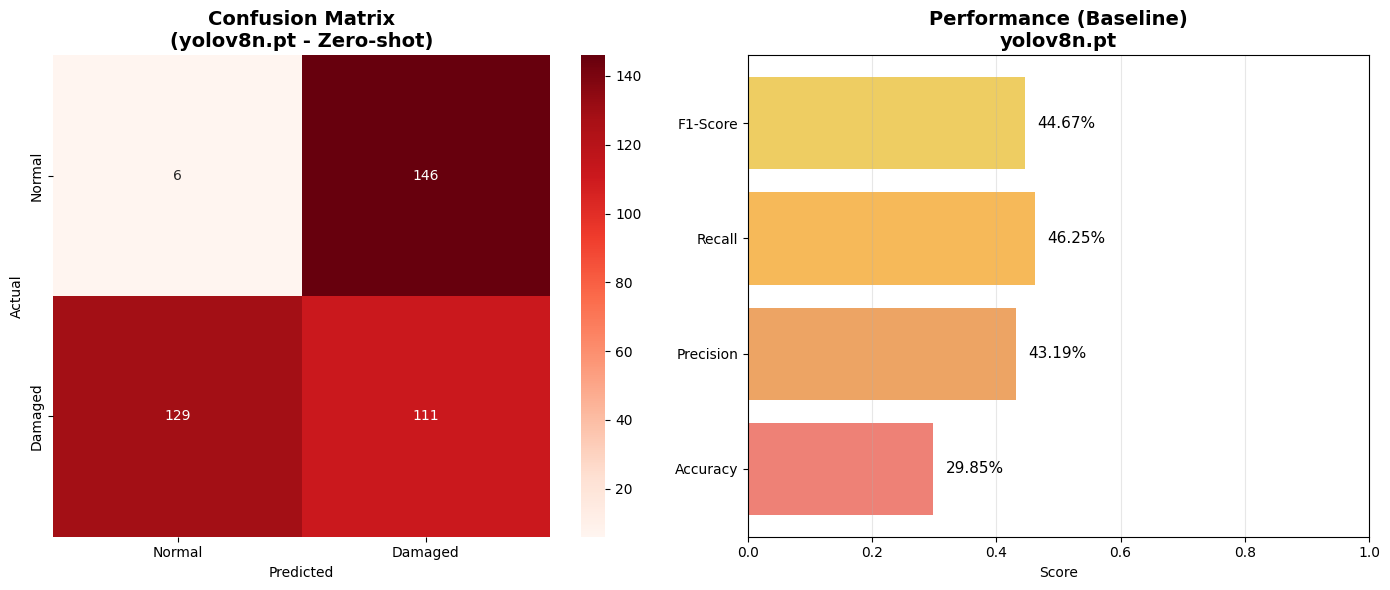


💾 그래프 저장: baseline_evaluation.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# 사용 방법:

# 1. 기본 모델로 평가
evaluator = BaselineEvaluator(pretrained_model='yolov8n.pt')

# 2. Validation 데이터로 평가
evaluator.evaluate_dataset(
    image_folder='/content/drive/MyDrive/yolo_dataset/images/val',
    label_folder='/content/drive/MyDrive/yolo_dataset/labels/val',
    conf_threshold=0.5
)

# 3. 메트릭 계산
metrics = evaluator.calculate_metrics()

# 4. 결과 저장
evaluator.save_results(output_prefix='baseline')

# 5. 시각화
evaluator.visualize_results()

# 6. 다운로드
from google.colab import files
files.download('baseline_metrics.csv')
files.download('baseline_evaluation.png')



In [11]:
# ============================================
# 검증 결과를 간단한 CSV로 저장
# filename, ground_truth, prediction, correct, result_type
# ============================================

import pandas as pd
import os
from tqdm import tqdm

def create_validation_csv(
    model_path,
    image_folder='/content/drive/MyDrive/yolo_dataset/images/val',
    label_folder='/content/drive/MyDrive/yolo_dataset/labels/val',
    conf_threshold=0.5,
    output_filename='validation_results.csv'
):
    """
    검증 결과를 CSV로 생성

    Args:
        model_path: 모델 경로 (예: 'car_damage_model/train/weights/best.pt')
        image_folder: 검증 이미지 폴더
        label_folder: 검증 라벨 폴더
        conf_threshold: Confidence threshold
        output_filename: 출력 CSV 파일명

    Returns:
        DataFrame
    """
    from ultralytics import YOLO

    print("="*60)
    print("📊 검증 결과 CSV 생성")
    print("="*60)

    # 모델 로드
    print(f"\n🔧 모델 로드: {model_path}")
    model = YOLO(model_path)

    # 이미지 목록
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    print(f"✅ 이미지 개수: {len(image_files)}개")
    print(f"📁 저장 파일: {output_filename}\n")

    # 결과 저장 리스트
    results = []

    # 각 이미지 평가
    for img_file in tqdm(image_files, desc="평가 진행"):
        img_path = os.path.join(image_folder, img_file)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(label_folder, label_file)

        # Ground Truth
        ground_truth = 'normal'
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                content = f.read().strip()
                if len(content) > 0:
                    ground_truth = 'damaged'

        # 예측
        pred_results = model.predict(img_path, conf=conf_threshold, verbose=False)
        detections = pred_results[0].boxes
        prediction = 'damaged' if len(detections) > 0 else 'normal'

        # 정확도 및 결과 타입
        correct = (ground_truth == prediction)

        # Result Type
        if ground_truth == 'damaged' and prediction == 'damaged':
            result_type = 'TP'  # True Positive
        elif ground_truth == 'normal' and prediction == 'normal':
            result_type = 'TN'  # True Negative
        elif ground_truth == 'normal' and prediction == 'damaged':
            result_type = 'FP'  # False Positive (오탐)
        elif ground_truth == 'damaged' and prediction == 'normal':
            result_type = 'FN'  # False Negative (미탐)
        else:
            result_type = 'Unknown'

        # 결과 추가
        results.append({
            'filename': img_file,
            'ground_truth': ground_truth,
            'prediction': prediction,
            'correct': correct,
            'result_type': result_type
        })

    # DataFrame 생성
    df = pd.DataFrame(results)

    # CSV 저장
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')

    # 결과 요약
    print(f"\n{'='*60}")
    print(f"✅ CSV 생성 완료!")
    print(f"{'='*60}")
    print(f"파일명: {output_filename}")
    print(f"총 이미지: {len(df)}개")
    print(f"\n결과 분포:")
    print(f"  TP (파손→파손): {len(df[df['result_type']=='TP'])}개")
    print(f"  TN (정상→정상): {len(df[df['result_type']=='TN'])}개")
    print(f"  FP (정상→파손, 오탐): {len(df[df['result_type']=='FP'])}개")
    print(f"  FN (파손→정상, 미탐): {len(df[df['result_type']=='FN'])}개")

    accuracy = len(df[df['correct']==True]) / len(df)
    print(f"\n정확도: {accuracy:.2%}")
    print(f"{'='*60}")

    # 샘플 출력
    print(f"\n📋 샘플 (처음 10개):")
    print(df.head(10).to_string(index=False))

    return df


# ============================================
# 빠른 실행 함수들
# ============================================

def validate_trained_model(conf=0.5):
    """학습된 모델 검증"""

    print("\n🎯 학습된 모델 검증\n")

    df = create_validation_csv(
        model_path='/content/drive/MyDrive/car_damage_model/train/weights/best.pt',
        conf_threshold=conf,
        output_filename='validation_results.csv'
    )

    return df


def validate_baseline_model(conf=0.5):
    """기본 모델 검증 (학습 전)"""

    print("\n🎯 기본 모델 검증 (학습 전)\n")

    df = create_validation_csv(
        model_path='yolov8n.pt',
        conf_threshold=conf,
        output_filename='baseline_results.csv'
    )

    return df


def compare_models():
    """두 모델 비교"""

    print("\n" + "="*60)
    print("📊 학습 전/후 비교")
    print("="*60)

    # 기본 모델
    print("\n1️⃣  기본 모델 (학습 전)")
    baseline_df = validate_baseline_model()

    # 학습된 모델
    print("\n\n2️⃣  학습된 모델")
    trained_df = validate_trained_model()

    # 비교표
    print("\n\n" + "="*60)
    print("📈 비교 결과")
    print("="*60)

    baseline_acc = len(baseline_df[baseline_df['correct']==True]) / len(baseline_df)
    trained_acc = len(trained_df[trained_df['correct']==True]) / len(trained_df)

    baseline_tp = len(baseline_df[baseline_df['result_type']=='TP'])
    trained_tp = len(trained_df[trained_df['result_type']=='TP'])

    baseline_fp = len(baseline_df[baseline_df['result_type']=='FP'])
    trained_fp = len(trained_df[trained_df['result_type']=='FP'])

    baseline_fn = len(baseline_df[baseline_df['result_type']=='FN'])
    trained_fn = len(trained_df[trained_df['result_type']=='FN'])

    print(f"\n{'지표':<20} {'기본 모델':<15} {'학습된 모델':<15} {'개선':<15}")
    print("-" * 70)
    print(f"{'Accuracy':<20} {baseline_acc:>7.2%}        {trained_acc:>7.2%}        {trained_acc-baseline_acc:>+7.2%}")
    print(f"{'TP (정확한 파손)':<20} {baseline_tp:>7}개       {trained_tp:>7}개       {trained_tp-baseline_tp:>+7}개")
    print(f"{'FP (오탐)':<20} {baseline_fp:>7}개       {trained_fp:>7}개       {trained_fp-baseline_fp:>+7}개")
    print(f"{'FN (미탐)':<20} {baseline_fn:>7}개       {trained_fn:>7}개       {trained_fn-baseline_fn:>+7}개")

    print("\n💡 학습 효과:")
    if trained_acc > baseline_acc:
        improvement = (trained_acc - baseline_acc) * 100
        print(f"✅ 정확도 {improvement:.1f}%p 향상!")
    else:
        print(f"⚠️  학습 효과 미미")

    return baseline_df, trained_df


def filter_results(df, result_type=None):
    """특정 결과 타입만 필터링"""

    if result_type:
        filtered = df[df['result_type'] == result_type]
        print(f"\n{result_type} 결과: {len(filtered)}개")
        return filtered
    else:
        print("\n전체 결과:")
        print(df['result_type'].value_counts())
        return df


def download_csv(filename='validation_results.csv'):
    """CSV 다운로드"""
    from google.colab import files

    if os.path.exists(filename):
        print(f"📥 다운로드 중: {filename}")
        files.download(filename)
    else:
        print(f"❌ 파일 없음: {filename}")


# ============================================
# 사용 예제
# ============================================

print("\n\n" + "="*60)
print("💡 사용 방법")
print("="*60)

print("""
# ============================================
# 방법 1: 학습된 모델 검증 (가장 기본)
# ============================================

df = validate_trained_model(conf=0.5)

# 다운로드
download_csv('validation_results.csv')


# ============================================
# 방법 2: 기본 모델 검증 (Baseline)
# ============================================

df = validate_baseline_model(conf=0.5)

# 다운로드
download_csv('baseline_results.csv')


# ============================================
# 방법 3: 두 모델 비교
# ============================================

baseline_df, trained_df = compare_models()

# 다운로드
download_csv('baseline_results.csv')
download_csv('validation_results.csv')


# ============================================
# 방법 4: 커스텀 설정
# ============================================

df = create_validation_csv(
    model_path='car_damage_model/train/weights/best.pt',
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.7,  # Confidence 조정
    output_filename='my_validation.csv'
)


# ============================================
# 결과 필터링
# ============================================

# 오탐만 보기
fp_df = filter_results(df, 'FP')
print(fp_df)

# 미탐만 보기
fn_df = filter_results(df, 'FN')
print(fn_df)

# 전체 분포
filter_results(df)
""")

print("\n" + "="*60)
print("✅ 준비 완료! 위 코드를 실행하세요.")
print("="*60)


# ============================================
# 가장 간단한 실행 (권장)
# ============================================

print("\n\n" + "="*60)
print("⚡ 가장 빠른 실행")
print("="*60)

print("""
새 셀에서 실행:

# 학습된 모델 검증
df = validate_trained_model()

# 또는 기본 모델 검증
# df = validate_baseline_model()

# 또는 둘 다 비교
# baseline_df, trained_df = compare_models()
""")




💡 사용 방법

# ============================================
# 방법 1: 학습된 모델 검증 (가장 기본)
# ============================================

df = validate_trained_model(conf=0.5)

# 다운로드
download_csv('validation_results.csv')


# ============================================
# 방법 2: 기본 모델 검증 (Baseline)
# ============================================

df = validate_baseline_model(conf=0.5)

# 다운로드
download_csv('baseline_results.csv')


# ============================================
# 방법 3: 두 모델 비교
# ============================================

baseline_df, trained_df = compare_models()

# 다운로드
download_csv('baseline_results.csv')
download_csv('validation_results.csv')


# ============================================
# 방법 4: 커스텀 설정
# ============================================

df = create_validation_csv(
    model_path='car_damage_model/train/weights/best.pt',
    image_folder='yolo_dataset/images/val',
    label_folder='yolo_dataset/labels/val',
    conf_threshold=0.7,  # Confidence 조정
    outp

In [12]:

# ============================================
# 방법 1: 학습된 모델 검증 (가장 기본)
# ============================================

df = validate_trained_model(conf=0.5)

# 다운로드
download_csv('validation_results.csv')


# ============================================
# 방법 2: 기본 모델 검증 (Baseline)
# ============================================

df = validate_baseline_model(conf=0.5)

# 다운로드
download_csv('baseline_results.csv')


# ============================================
# 방법 3: 두 모델 비교
# ============================================

baseline_df, trained_df = compare_models()

# 다운로드
download_csv('baseline_results.csv')
download_csv('validation_results.csv')


# ============================================
# 방법 4: 커스텀 설정
# ============================================

df = create_validation_csv(
    model_path='/content/drive/MyDrive/car_damage_model/train/weights/best.pt',
    image_folder='/content/drive/MyDrive/yolo_dataset/images/val',
    label_folder='/content/drive/MyDrive/yolo_dataset/labels/val',
    conf_threshold=0.7,  # Confidence 조정
    output_filename='my_validation.csv'
)


# ============================================
# 결과 필터링
# ============================================

# 오탐만 보기
fp_df = filter_results(df, 'FP')
print(fp_df)

# 미탐만 보기
fn_df = filter_results(df, 'FN')
print(fn_df)

# 전체 분포
filter_results(df)

# 학습된 모델 검증
df = validate_trained_model()

# 또는 기본 모델 검증
# df = validate_baseline_model()

# 또는 둘 다 비교
# baseline_df, trained_df = compare_models()


🎯 학습된 모델 검증

📊 검증 결과 CSV 생성

🔧 모델 로드: /content/drive/MyDrive/car_damage_model/train/weights/best.pt
✅ 이미지 개수: 392개
📁 저장 파일: validation_results.csv



평가 진행: 100%|██████████| 392/392 [01:24<00:00,  4.63it/s]


✅ CSV 생성 완료!
파일명: validation_results.csv
총 이미지: 392개

결과 분포:
  TP (파손→파손): 108개
  TN (정상→정상): 152개
  FP (정상→파손, 오탐): 0개
  FN (파손→정상, 미탐): 132개

정확도: 66.33%

📋 샘플 (처음 10개):
   filename ground_truth prediction  correct result_type
bg_0405.jpg       normal     normal     True          TN
bg_0013.jpg       normal     normal     True          TN
bg_0435.jpg       normal     normal     True          TN
bg_0259.jpg       normal     normal     True          TN
bg_0392.jpg       normal     normal     True          TN
bg_0477.jpg       normal     normal     True          TN
bg_0598.jpg       normal     normal     True          TN
bg_0474.jpg       normal     normal     True          TN
bg_0492.jpg       normal     normal     True          TN
bg_0369.jpg       normal     normal     True          TN
📥 다운로드 중: validation_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 기본 모델 검증 (학습 전)

📊 검증 결과 CSV 생성

🔧 모델 로드: yolov8n.pt
✅ 이미지 개수: 392개
📁 저장 파일: baseline_results.csv



평가 진행: 100%|██████████| 392/392 [01:25<00:00,  4.60it/s]


✅ CSV 생성 완료!
파일명: baseline_results.csv
총 이미지: 392개

결과 분포:
  TP (파손→파손): 111개
  TN (정상→정상): 6개
  FP (정상→파손, 오탐): 146개
  FN (파손→정상, 미탐): 129개

정확도: 29.85%

📋 샘플 (처음 10개):
   filename ground_truth prediction  correct result_type
bg_0405.jpg       normal    damaged    False          FP
bg_0013.jpg       normal    damaged    False          FP
bg_0435.jpg       normal    damaged    False          FP
bg_0259.jpg       normal    damaged    False          FP
bg_0392.jpg       normal    damaged    False          FP
bg_0477.jpg       normal    damaged    False          FP
bg_0598.jpg       normal    damaged    False          FP
bg_0474.jpg       normal    damaged    False          FP
bg_0492.jpg       normal    damaged    False          FP
bg_0369.jpg       normal    damaged    False          FP
📥 다운로드 중: baseline_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 학습 전/후 비교

1️⃣  기본 모델 (학습 전)

🎯 기본 모델 검증 (학습 전)

📊 검증 결과 CSV 생성

🔧 모델 로드: yolov8n.pt
✅ 이미지 개수: 392개
📁 저장 파일: baseline_results.csv



평가 진행: 100%|██████████| 392/392 [01:27<00:00,  4.49it/s]



✅ CSV 생성 완료!
파일명: baseline_results.csv
총 이미지: 392개

결과 분포:
  TP (파손→파손): 111개
  TN (정상→정상): 6개
  FP (정상→파손, 오탐): 146개
  FN (파손→정상, 미탐): 129개

정확도: 29.85%

📋 샘플 (처음 10개):
   filename ground_truth prediction  correct result_type
bg_0405.jpg       normal    damaged    False          FP
bg_0013.jpg       normal    damaged    False          FP
bg_0435.jpg       normal    damaged    False          FP
bg_0259.jpg       normal    damaged    False          FP
bg_0392.jpg       normal    damaged    False          FP
bg_0477.jpg       normal    damaged    False          FP
bg_0598.jpg       normal    damaged    False          FP
bg_0474.jpg       normal    damaged    False          FP
bg_0492.jpg       normal    damaged    False          FP
bg_0369.jpg       normal    damaged    False          FP


2️⃣  학습된 모델

🎯 학습된 모델 검증

📊 검증 결과 CSV 생성

🔧 모델 로드: /content/drive/MyDrive/car_damage_model/train/weights/best.pt
✅ 이미지 개수: 392개
📁 저장 파일: validation_results.csv



평가 진행: 100%|██████████| 392/392 [01:20<00:00,  4.86it/s]


✅ CSV 생성 완료!
파일명: validation_results.csv
총 이미지: 392개

결과 분포:
  TP (파손→파손): 108개
  TN (정상→정상): 152개
  FP (정상→파손, 오탐): 0개
  FN (파손→정상, 미탐): 132개

정확도: 66.33%

📋 샘플 (처음 10개):
   filename ground_truth prediction  correct result_type
bg_0405.jpg       normal     normal     True          TN
bg_0013.jpg       normal     normal     True          TN
bg_0435.jpg       normal     normal     True          TN
bg_0259.jpg       normal     normal     True          TN
bg_0392.jpg       normal     normal     True          TN
bg_0477.jpg       normal     normal     True          TN
bg_0598.jpg       normal     normal     True          TN
bg_0474.jpg       normal     normal     True          TN
bg_0492.jpg       normal     normal     True          TN
bg_0369.jpg       normal     normal     True          TN


📈 비교 결과

지표                   기본 모델           학습된 모델          개선             
----------------------------------------------------------------------
Accuracy              29.85%         66.33%      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드 중: validation_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 검증 결과 CSV 생성

🔧 모델 로드: /content/drive/MyDrive/car_damage_model/train/weights/best.pt
✅ 이미지 개수: 392개
📁 저장 파일: my_validation.csv



평가 진행: 100%|██████████| 392/392 [01:19<00:00,  4.92it/s]



✅ CSV 생성 완료!
파일명: my_validation.csv
총 이미지: 392개

결과 분포:
  TP (파손→파손): 62개
  TN (정상→정상): 152개
  FP (정상→파손, 오탐): 0개
  FN (파손→정상, 미탐): 178개

정확도: 54.59%

📋 샘플 (처음 10개):
   filename ground_truth prediction  correct result_type
bg_0405.jpg       normal     normal     True          TN
bg_0013.jpg       normal     normal     True          TN
bg_0435.jpg       normal     normal     True          TN
bg_0259.jpg       normal     normal     True          TN
bg_0392.jpg       normal     normal     True          TN
bg_0477.jpg       normal     normal     True          TN
bg_0598.jpg       normal     normal     True          TN
bg_0474.jpg       normal     normal     True          TN
bg_0492.jpg       normal     normal     True          TN
bg_0369.jpg       normal     normal     True          TN

FP 결과: 0개
Empty DataFrame
Columns: [filename, ground_truth, prediction, correct, result_type]
Index: []

FN 결과: 178개
                   filename ground_truth prediction  correct result_type
76   0034390_as

평가 진행: 100%|██████████| 392/392 [01:19<00:00,  4.95it/s]


✅ CSV 생성 완료!
파일명: validation_results.csv
총 이미지: 392개

결과 분포:
  TP (파손→파손): 108개
  TN (정상→정상): 152개
  FP (정상→파손, 오탐): 0개
  FN (파손→정상, 미탐): 132개

정확도: 66.33%

📋 샘플 (처음 10개):
   filename ground_truth prediction  correct result_type
bg_0405.jpg       normal     normal     True          TN
bg_0013.jpg       normal     normal     True          TN
bg_0435.jpg       normal     normal     True          TN
bg_0259.jpg       normal     normal     True          TN
bg_0392.jpg       normal     normal     True          TN
bg_0477.jpg       normal     normal     True          TN
bg_0598.jpg       normal     normal     True          TN
bg_0474.jpg       normal     normal     True          TN
bg_0492.jpg       normal     normal     True          TN
bg_0369.jpg       normal     normal     True          TN
